In [ ]:
import numpy as np

# Data utilities
from pandas import read_csv
import matplotlib.pyplot as plt
import os.path
import torch
import h5py

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_val_score

## Open embedding file

In [ ]:
proteins = []

In [ ]:
with h5py.File('/gdrive/MyDrive/DNA Binding Protein/DNA-Binding Proteins/Embeddings/PDB1063.h5', 'r') as f:
    for new_identifier in f.keys():
        proteins.append((new_identifier, np.array(f[new_identifier])))

In [ ]:
with h5py.File('/gdrive/MyDrive/DNA Binding Protein/DNA-Binding Proteins/Embeddings/PDB186.h5', 'r') as f:
    for new_identifier in f.keys():
        proteins.append((new_identifier, np.array(f[new_identifier])))

In [ ]:
# Basic Protocol 3 — Step 5
annotations = read_csv('/gdrive/MyDrive/DNA Binding Protein/DNA-Binding Proteins/Datasets/set2unreduced.csv')

In [ ]:
annotations[:3]

,identifier,sequence,label,set
0,1AKHB,TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...,1,train
1,1B6WA,MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...,1,train
2,1C1KA,MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...,1,train


In [ ]:
# Basic Protocol 3 — Step 6
train_set = annotations[annotations.set == "train"]
test_set = annotations[annotations.set == "test"]

In [ ]:
print(f"The train set contains {len(train_set)} samples, and we will test on {len(test_set)} samples.")

The train set contains 1063 samples, and we will test on 186 samples.


In [ ]:
# Basic Protocol 3 — Step 7

training_embeddings = list()
training_identifiers = train_set.identifier.values
training_labels = train_set.label.values
print(len(training_identifiers))
print(len(training_labels))

1063
1063


In [ ]:
train_set.identifier.values

array(['1AKHB', '1B6WA', '1C1KA', ..., '3QBDA', '3QB4A', '2L8BA'],
      dtype=object)

In [ ]:
testing_embeddings = list()
testing_identifiers = test_set.identifier.values
testing_labels = test_set.label.values
print(len(testing_identifiers))
print(len(testing_labels))

186
186


In [ ]:
seq = dict(proteins)
delete = list()

In [ ]:
for identifier in training_identifiers:
        if identifier in seq:
            embedding = seq[identifier]
            training_embeddings.append(embedding)
        else:
          delete.append(identifier)

In [ ]:
for identifier in testing_identifiers:
        if identifier in seq:
            embedding = seq[identifier]
            testing_embeddings.append(embedding)
        else:
          delete.append(identifier)

In [ ]:
np.where(testing_identifiers=='P22336')

(array([], dtype=int64),)

# Training

In [ ]:
arr_train = np.array(training_embeddings)
nsample, nx, ny = arr_train.shape
train_dataset = arr_train.reshape((nsample, nx*ny))
train_dataset.shape

(1063, 1024)

In [ ]:
arr_test = np.array(testing_embeddings)
nsample, nx, ny = arr_test.shape
test_dataset = arr_test.reshape((nsample, nx*ny))
test_dataset.shape

(186, 1024)

In [ ]:
def load_data_embedding():
    SEED = 42
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    # the data, shuffled and split between train and test sets
   
    # create train dataset
    
    arr_train = np.array(training_embeddings)
    nsample, nx, ny = arr_train.shape
    train_dataset = arr_train.reshape((nsample, nx*ny))
    
       
    # create test dataset

    arr_test = np.array(testing_embeddings)
    nsample, nx, ny = arr_test.shape
    test_dataset = arr_test.reshape((nsample, nx*ny))

   

    # encode labels
    labels_train_encoded = to_categorical(
        training_labels, num_classes=2, dtype="float32"
    )  # (14189, 2)
    labels_test_encoded = to_categorical(
        testing_labels, num_classes=2, dtype="float32"
    )  # (2272, 2)
    
    

    return train_dataset, labels_train_encoded, test_dataset, labels_test_encoded

# Persiapan

In [ ]:
import datetime
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer,
    LSTM,
    Bidirectional,
    Embedding,
    Dense,
    Dropout,
    Flatten,
    Convolution1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


def create_dataset(data_path: str) -> Tuple[List[str], List[int]]:
    dataset = pd.read_csv(data_path)
    dataset = dataset.sample(frac=1).reset_index(drop=True)  # shuffle the dataset
    return list(dataset["sequence"]), list(dataset["label"])


def split_dataset(
    sequences_list: List[str], labels_list: List[int], train_size: float = 0.8
) -> Tuple[List[str], List[str], List[str], List[int], List[int], List[int]]:
    dataset = pd.DataFrame({"sequence": sequences_list, "label": labels_list})
    dataset = dataset.sample(frac=1, random_state=1)
    train, remaining = train_test_split(dataset, train_size=train_size, random_state=2)
    valid, test = train_test_split(remaining, test_size=0.5, random_state=3)
    x_train, x_valid, x_test = train["sequence"], valid["sequence"], test["sequence"]
    y_train, y_valid, y_test = train["label"], valid["label"], test["label"]
    return (
        list(x_train),
        list(x_valid),
        list(x_test),
        list(y_train),
        list(y_valid),
        list(y_test),
    )


def one_hot_encoding(
    sequence: str,
    max_seq_length: int = 1000,
    CONSIDERED_AA: str = "ACDEFGHIKLMNPQRSTVWY",
):
    # adapt sequence size
    if len(sequence) > max_seq_length:
        # short the sequence
        sequence = sequence[:max_seq_length]
    else:
        # pad the sequence
        sequence = sequence + "." * (max_seq_length - len(sequence))

    # encode sequence
    encoded_sequence = np.zeros((max_seq_length, len(CONSIDERED_AA)))  # (1000, 20)
    for i, amino_acid in enumerate(sequence):
        if amino_acid in CONSIDERED_AA:
            encoded_sequence[i][CONSIDERED_AA.index(amino_acid)] = 1
    model_input = np.expand_dims(encoded_sequence, 0)  # add batch dimension

    return model_input  # (1, 1000, 20)


def preprocess_word_embedding_encoding(
    sequence: str,
    max_seq_length: int = 1000,
    CONSIDERED_AA: str = "ACDEFGHIKLMNPQRSTVWY",
):
    # amino acids encoding
    aa_mapping = {aa: i + 1 for i, aa in enumerate(CONSIDERED_AA)}

    # adapt sequence size
    if len(sequence) > max_seq_length:
        # short the sequence
        sequence = sequence[:max_seq_length]
    else:
        # pad the sequence
        sequence = sequence + "." * (max_seq_length - len(sequence))

    # encode sequence
    encoded_sequence = np.zeros((max_seq_length,))  # (1000,)
    for i, amino_acid in enumerate(sequence):
        if amino_acid in CONSIDERED_AA:
            encoded_sequence[i] = aa_mapping[amino_acid]
    model_input = np.expand_dims(encoded_sequence, 0)  # add batch dimension

    return model_input  # (1, 1000)

In [ ]:
import numpy as np
import tensorflow as tf
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

# Capsule Network

In [ ]:
from keras.backend import *
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops


#own_batch_dot = batch_dot  # force standard implementation 

# import of batch_dot operation from TF 1.13
# https://github.com/tensorflow/tensorflow/blob/v1.13.1/tensorflow/python/keras/backend.py

def own_batch_dot(x, y, axes=None):
  """Batchwise dot product.
  `batch_dot` is used to compute dot product of `x` and `y` when
  `x` and `y` are data in batch, i.e. in a shape of
  `(batch_size, :)`.
  `batch_dot` results in a tensor or variable with less dimensions
  than the input. If the number of dimensions is reduced to 1,
  we use `expand_dims` to make sure that ndim is at least 2.
  Arguments:
      x: Keras tensor or variable with `ndim >= 2`.
      y: Keras tensor or variable with `ndim >= 2`.
      axes: list of (or single) int with target dimensions.
          The lengths of `axes[0]` and `axes[1]` should be the same.
  Returns:
      A tensor with shape equal to the concatenation of `x`'s shape
      (less the dimension that was summed over) and `y`'s shape
      (less the batch dimension and the dimension that was summed over).
      If the final rank is 1, we reshape it to `(batch_size, 1)`.
  Examples:
      Assume `x = [[1, 2], [3, 4]]` and `y = [[5, 6], [7, 8]]`
      `batch_dot(x, y, axes=1) = [[17, 53]]` which is the main diagonal
      of `x.dot(y.T)`, although we never have to calculate the off-diagonal
      elements.
      Shape inference:
      Let `x`'s shape be `(100, 20)` and `y`'s shape be `(100, 30, 20)`.
      If `axes` is (1, 2), to find the output shape of resultant tensor,
          loop through each dimension in `x`'s shape and `y`'s shape:
      * `x.shape[0]` : 100 : append to output shape
      * `x.shape[1]` : 20 : do not append to output shape,
          dimension 1 of `x` has been summed over. (`dot_axes[0]` = 1)
      * `y.shape[0]` : 100 : do not append to output shape,
          always ignore first dimension of `y`
      * `y.shape[1]` : 30 : append to output shape
      * `y.shape[2]` : 20 : do not append to output shape,
          dimension 2 of `y` has been summed over. (`dot_axes[1]` = 2)
      `output_shape` = `(100, 30)`
  ```python
      >>> x_batch = K.ones(shape=(32, 20, 1))
      >>> y_batch = K.ones(shape=(32, 30, 20))
      >>> xy_batch_dot = K.batch_dot(x_batch, y_batch, axes=[1, 2])
      >>> K.int_shape(xy_batch_dot)
      (32, 1, 30)
  ```
  """
  if isinstance(axes, int):
    axes = (axes, axes)
  x_ndim = ndim(x)
  y_ndim = ndim(y)
  if axes is None:
    # behaves like tf.batch_matmul as default
    axes = [x_ndim - 1, y_ndim - 2]
  if x_ndim > y_ndim:
    diff = x_ndim - y_ndim
    y = array_ops.reshape(y,
                          array_ops.concat(
                              [array_ops.shape(y), [1] * (diff)], axis=0))
  elif y_ndim > x_ndim:
    diff = y_ndim - x_ndim
    x = array_ops.reshape(x,
                          array_ops.concat(
                              [array_ops.shape(x), [1] * (diff)], axis=0))
  else:
    diff = 0
  if ndim(x) == 2 and ndim(y) == 2:
    if axes[0] == axes[1]:
      out = math_ops.reduce_sum(math_ops.multiply(x, y), axes[0])
    else:
      out = math_ops.reduce_sum(
          math_ops.multiply(array_ops.transpose(x, [1, 0]), y), axes[1])
  else:
    adj_x = None if axes[0] == ndim(x) - 1 else True
    adj_y = True if axes[1] == ndim(y) - 1 else None
    out = math_ops.matmul(x, y, adjoint_a=adj_x, adjoint_b=adj_y)
  if diff:
    if x_ndim > y_ndim:
      idx = x_ndim + y_ndim - 3
    else:
      idx = x_ndim - 1
    out = array_ops.squeeze(out, list(range(idx, idx + diff)))
  if ndim(out) == 1:
    out = expand_dims(out, 1)
  return out 

In [ ]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=tf.shape(x)[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param num_routing: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=(self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule),
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: own_batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        b = K.zeros(shape=[self.batch_size, self.num_capsule, self.input_num_capsule])
        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=1)  # dim=2 is the num_capsule dimension
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))
            if i != 1:
                b = b + K.batch_dot(outputs, inputs_hat, [2, 3])
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), b, K.sum(inputs_hat, 2, keepdims=False)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.num_capsule, self.input_num_capsule]),
                            tf.TensorShape([None, self.num_capsule, self.dim_capsule])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing algorithm V1, dynamic ------------------------------------------------------------#
        """
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # In forward pass, `inputs_hat_stopped` = `inputs_hat`;
        # In backward, no gradient can flow from `inputs_hat_stopped` back to `inputs_hat`.
        inputs_hat_stopped = K.stop_gradient(inputs_hat)
        
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=(K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule))

        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # At last iteration, use `inputs_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.num_routing - 1:
                # c.shape =  [batch_size, num_capsule, input_num_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
                # outputs.shape=[None, num_capsule, dim_capsule]
                outputs = squash(own_batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]
            else:  # Otherwise, use `inputs_hat_stopped` to update `b`. No gradients flow on this path.
                outputs = squash(own_batch_dot(c, inputs_hat_stopped, [2, 2]))

                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += own_batch_dot(outputs, inputs_hat_stopped, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv1D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 23 09:31:07 2018
@author: Karush
"""

"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this. 
Usage:
       python capsulenet.py
       python capsulenet.py --epochs 50
       python capsulenet.py --epochs 50 --routings 3
       ... ...
       
Result:
    Validation accuracy > 99.5% after 20 epochs. Converge to 99.66% after 50 epochs.
    About 110 seconds per epoch on a single GTX1070 GPU card
    
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""
#import json
#
#with open("keras.json") as json_file:
#		s2 = json.load(json_file)
#with open("keras.json",'w') as json_file:
#    json.dump(s1,json_file) 


import numpy as np
import json
from keras import layers, models, optimizers
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from tensorflow.keras.utils import to_categorical
# from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

#%%

def CapsNet(input_shape,top_words, maxlen, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)


    # Bi-LSTM layer
    # s= Bidirectional(LSTM(256,return_sequences=True))(x)
    # s= LSTM(256,return_sequences=True)(x)
    # Layer 1: Just a conventional Conv1D layer
    conv1 = layers.Conv1D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    
    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=8, num_routing=routings,
                             name='digitcaps')(primarycaps)
    
    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps) 

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    dec_3 = decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid', input_dim=10*n_class))
#    dec_1 = decoder.add(layers.Dense(16, activation='relu', input_dim=10*n_class))
#    dec_2 = decoder.add(layers.Dense(16, activation='relu'))
#    decoder.add(layers.Dropout(0.40))
#    dec_3 = decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    dec_4 = decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model(x,out_caps) #masked_by_y
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 10))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model, eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


# Persiapan Kfold

In [ ]:
X_train,y_train,X_test,y_test = load_data_embedding()

In [ ]:
X_train[:,1].shape

(14188,)

In [ ]:
# split into samples (e.g. 14188/1 = 14188)
samples_train = list()
length = 1
n=14188
# step over the 5,000 in jumps of 200
for i in range(0,n,length):
 # grab from i to i + 200
 sample_train = X_train[i:i+length]
 samples_train.append(sample_train)
print(len(samples_train))

14188


In [ ]:
samples_test = list()
length = 1
n=2272
# step over the 5,000 in jumps of 200
for i in range(0,n,length):
 # grab from i to i + 200
 sample_test = X_test[i:i+length]
 samples_test.append(sample_test)
print(len(samples_test))

2272


In [ ]:
# convert list of arrays into 2d array
from numpy import array
data_train = array(samples_train)
data_test = array(samples_test)
print(data_train.shape)
print(data_test.shape)

(14188, 1, 1024)
(2272, 1, 1024)


In [ ]:
data_train = data_train.reshape((len(samples_train), 1024, 1))
data_test = data_test.reshape((len(samples_test), 1024, 1))

In [ ]:
data_train = data_train.reshape((len(samples_train), 1024,1))
data_test = data_test.reshape((len(samples_test), 1024, 1))
print(data_train.shape)
print(data_test.shape)

(14188, 1024, 1)
(2272, 1024, 1)


In [ ]:
train_dataset[1000].shape

(1024,)

In [ ]:
data_train.shape

(14188, 1024, 1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import KFold, StratifiedKFold
inputs = np.concatenate((data_train, data_test), axis=0)
targets = np.concatenate((y_train[1:], y_test), axis=0)

In [ ]:
print(inputs.shape)
print(targets.shape)

(16460, 1024, 1)
(16460, 2)


# Tarining Capsule Network

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 1016, 256)         2560      
                                                                 
 primarycap_conv2d (Conv1D)  (None, 504, 256)          590080    
                                                                 
 primarycap_reshape (Reshape  (None, 16128, 8)         0         
 )                                                               
                                                                 
 primarycap_squash (Lambda)  (None, 16128, 8)          0         
                                                                 
 digitcaps (CapsuleLayer)    (None, 2, 8)              2064384   
                                                             

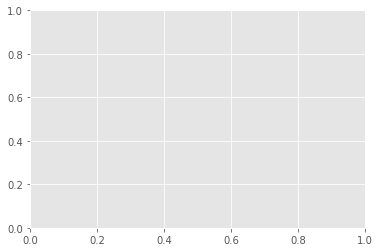

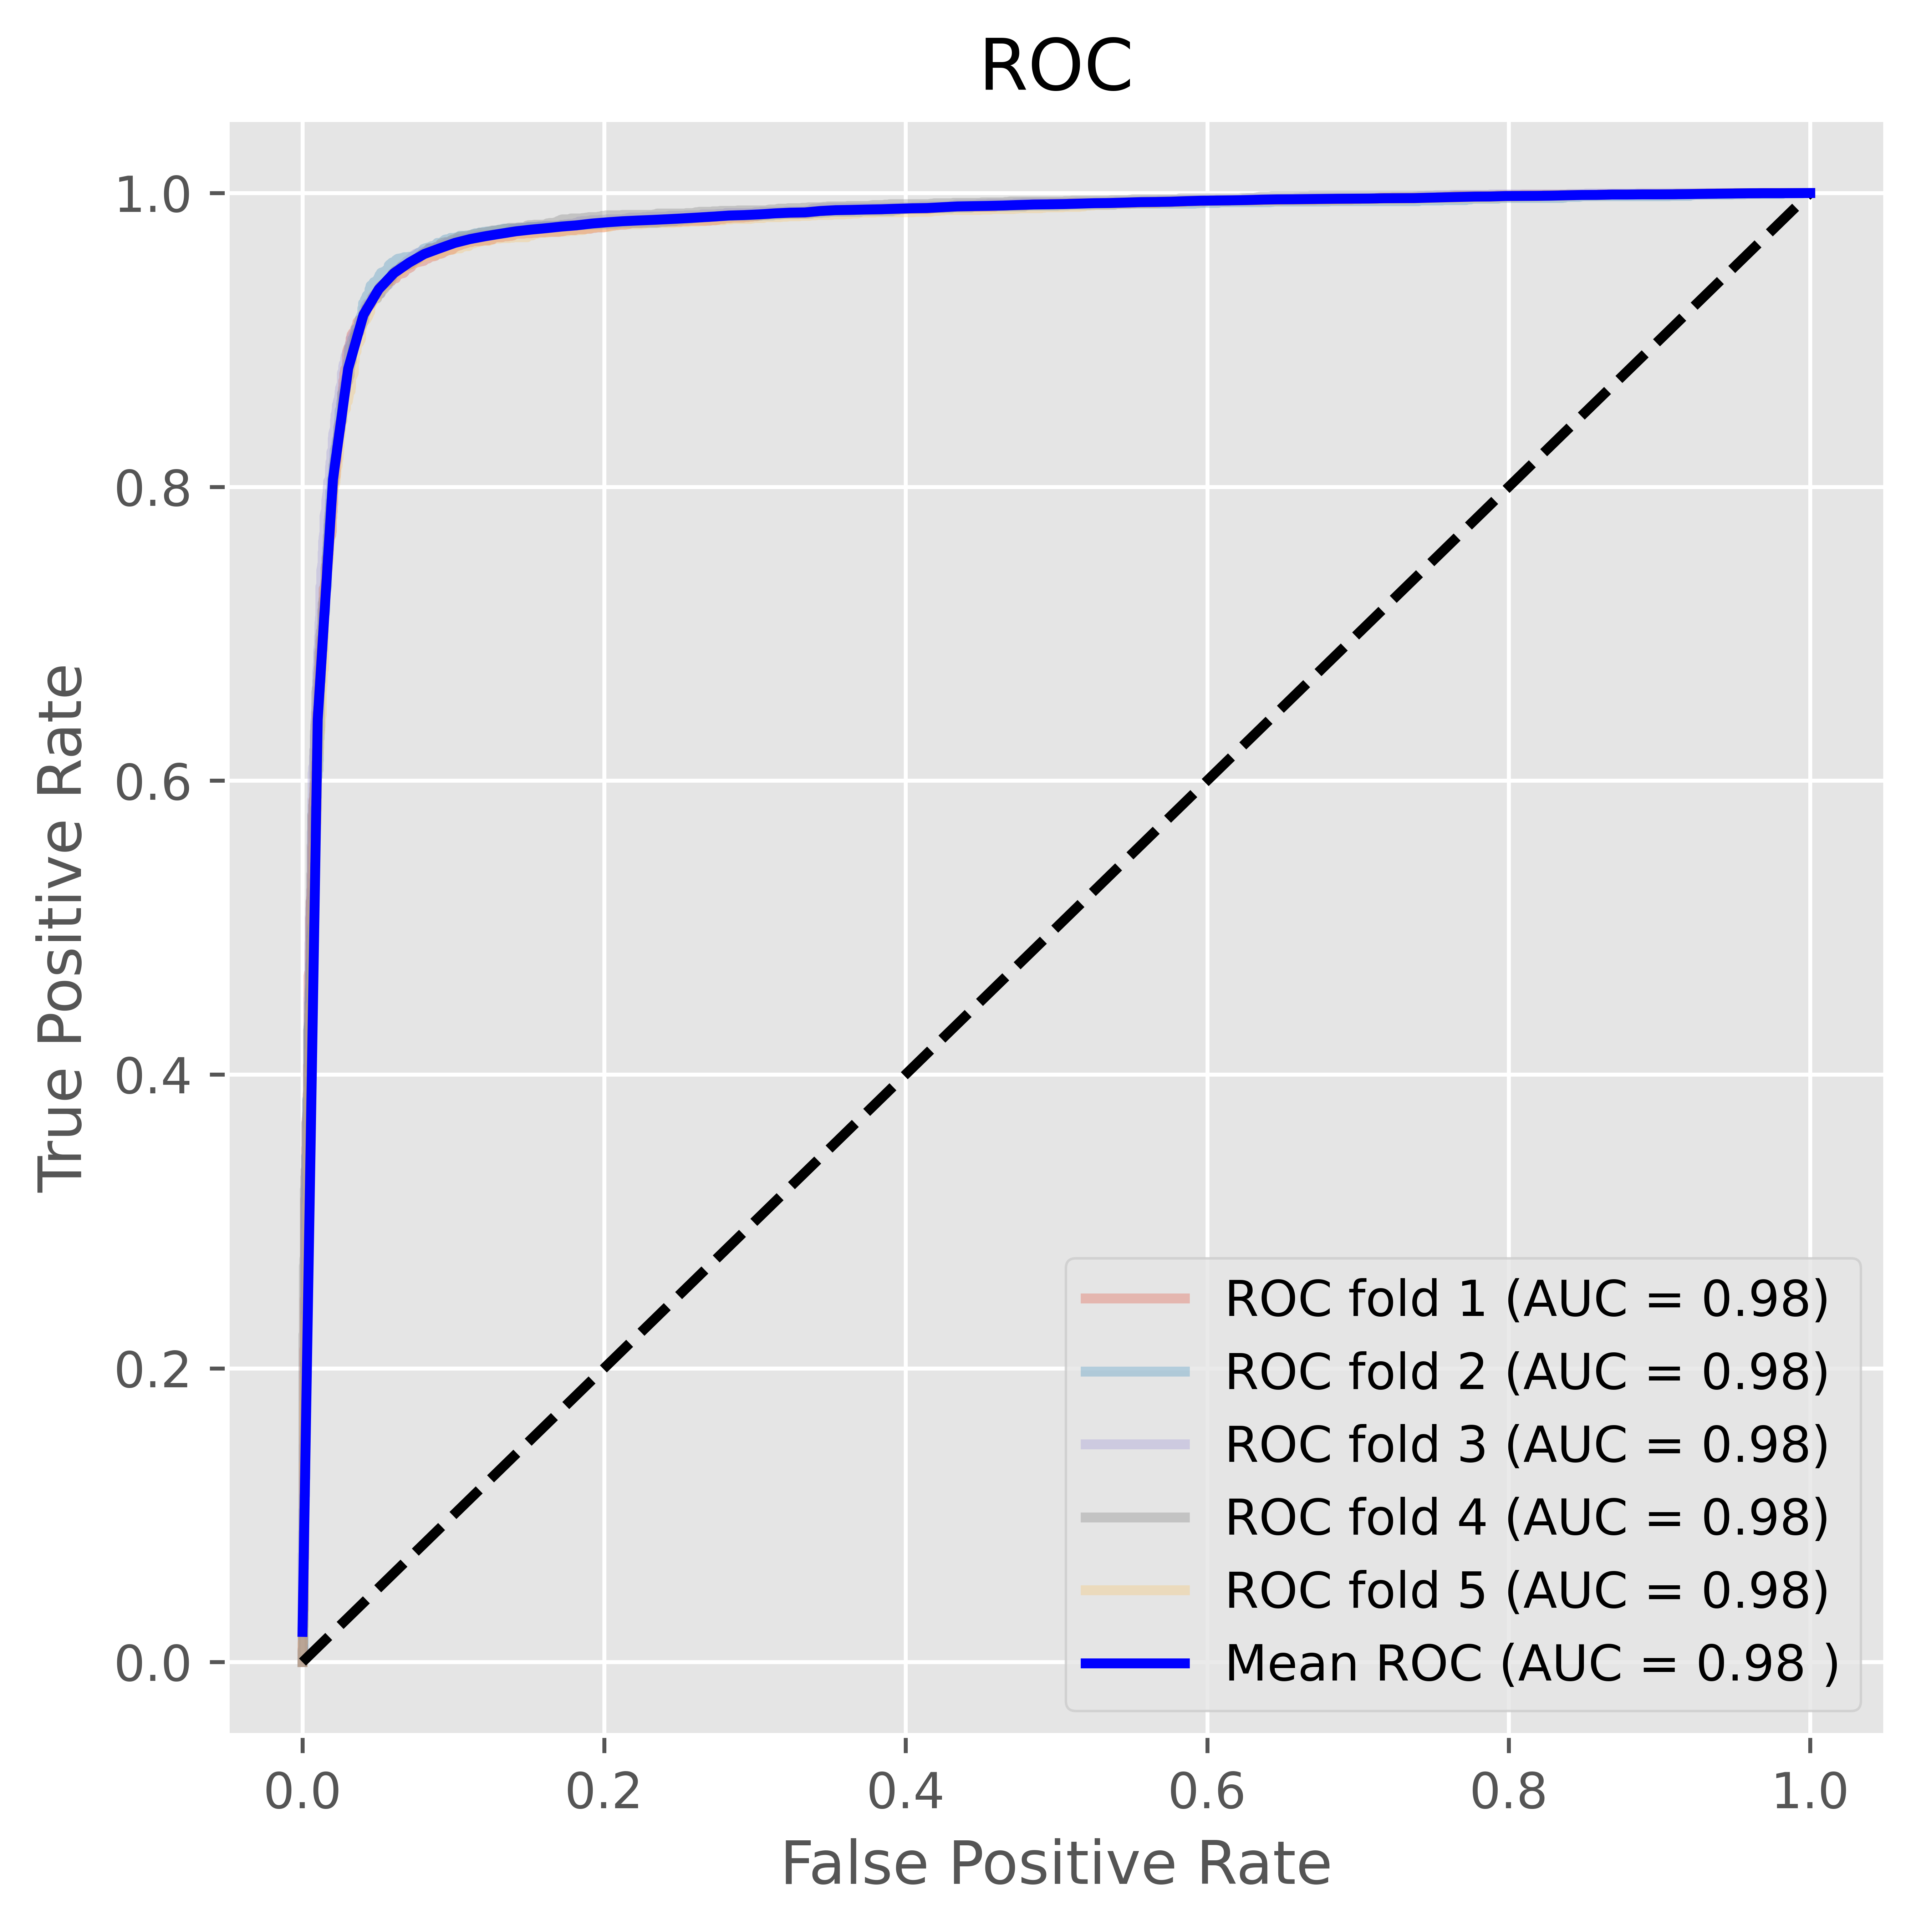

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from google.colab import files

acc_per_fold = []
loss_per_fold = []
sp_per_fold = []
prec_per_fold = []
sn_per_fold = []
AUC_per_fold = []
MCC_per_fold = []

tprs = []

aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 1
fig, ax = plt.subplots()

# seed = 7
# np.random.seed(seed)

epoch=30
# unpacking the data
# (x_train, y_train), (x_test, y_test) = data

# set amino acids to consider
CONSIDERED_AA = "ACDEFGHIKLMNPQRSTVWY"

# embedding and convolution parameters
MAX_SEQ_LENGTH = 1024
VOCAB_SIZE = len(CONSIDERED_AA)
# EMBEDDING_SIZE = 128
# plt.figure(1)
plt.figure(figsize=(6,6), dpi= 1000)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):


  model, eval_model = CapsNet(data_train[1,:].shape, VOCAB_SIZE, MAX_SEQ_LENGTH, n_class=2, routings=2)
  model.summary()


  # compile the model
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  loss=[margin_loss, 'binary_crossentropy'],
                  # loss_weights=[1., 0.392],
                  metrics=["accuracy", specificity, "Precision", "Recall", "AUC", matthews_correlation_coefficient])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=epoch,
              # validation_split=0.05,
              verbose=1)
    # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}; {model.metrics_names[6]} of {scores[6]}')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  sp_per_fold.append(scores[2])
  prec_per_fold.append(scores[3])
  sn_per_fold.append(scores[4])
  AUC_per_fold.append(scores[5])
  MCC_per_fold.append(scores[6])

  y_pred_keras = model.predict(inputs[test])
    
  fpr, tpr, thresholds = roc_curve(targets[test].ravel(), y_pred_keras.ravel())
  tprs.append(np.interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (fold_no, roc_auc))
  

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Specificity: {sp_per_fold[i]} - Precision: {prec_per_fold[i]} - Sensitivity: {sn_per_fold[i]} - AUC: {AUC_per_fold[i]} - MCC: {MCC_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Specificity: {np.mean(sp_per_fold)}')
print(f'> Precision: {np.mean(prec_per_fold)}')
print(f'> Sensitivity: {np.mean(sn_per_fold)}')
print(f'> AUC: {np.mean(AUC_per_fold)}')
print(f'> MCC: {np.mean(MCC_per_fold)}')
print('------------------------------------------------------------------------')

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
# image = plt.figure(figsize=(16,10), dpi= 200)

images_dir = "/gdrive/MyDrive"
plt.savefig(f"{images_dir}/PDB ESM 1b data 186 embedding epoch 30 1D capsnet saja 32 x40).JPG",dpi=1000)
plt.show()

# plt.savefig("DPB",dpi=500)
# tf.keras.models.save_model(model, filepath="/gdrive/MyDrive/DNA Binding Protein/Dbp app/logs3/model blstm Adam 100 epoch reduce plateu one hot 128 sequence 600",save_format='hdf5')